 #  <center> R语言空间插值的几种方法及案例应用<center> 

## 1.加载相关包

In [1]:
library(raster)
library(sp)
library(rgdal)
library(gstat)
library(raster)
library(maptools)
library(dismo)
library(fields)

Warning message:
"程辑包'raster'是用R版本4.2.1 来建造的"
载入需要的程辑包：sp

Warning message:
"程辑包'rgdal'是用R版本4.1.3 来建造的"
Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-30, (SVN revision 1171)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.4.1, released 2021/12/27
Path to GDAL shared files: D:/Rabout/R-4.1.2/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: D:/Rabout/R-4.1.2/library/rgdal/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-6
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

Warning message:
"程辑包'gstat'是用R版本4.2.1 来建造的"
Warning message:
"程辑包'maptools'是用R版本4.1.3 来建造的"
Checking rgeos availability: TRUE
Please no

## 2.读取数据
* 边界shp文件
* 数据shp文件
>备注：保证投影坐标系统一(R中转换不方便，建议在ArcGIS中完成)

OGR data source with driver: ESRI Shapefile 
Source: "D:\Desktop\武汉主城区shp\Export_Output.shp", layer: "Export_Output"
with 103 features
It has 5 fields
Integer64 fields read as strings:  OBJECTID 


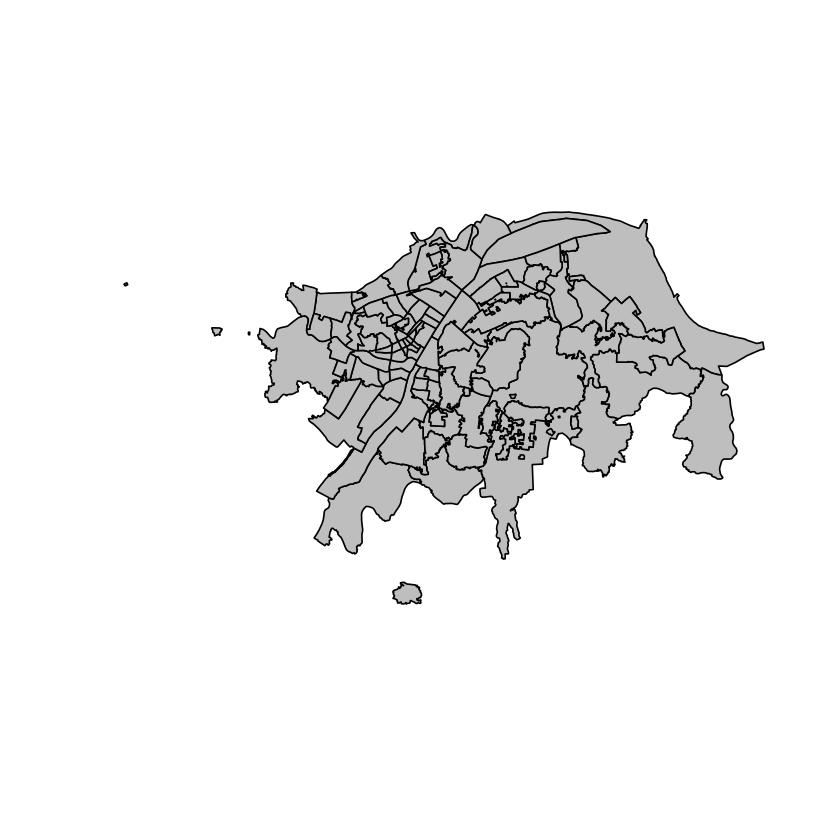

In [37]:
bound<-readOGR(file.choose())
plot(bound,col="grey")

OGR data source with driver: ESRI Shapefile 
Source: "D:\Desktop\R语言空间插值\data\out.shp", layer: "out"
with 9 features
It has 9 fields


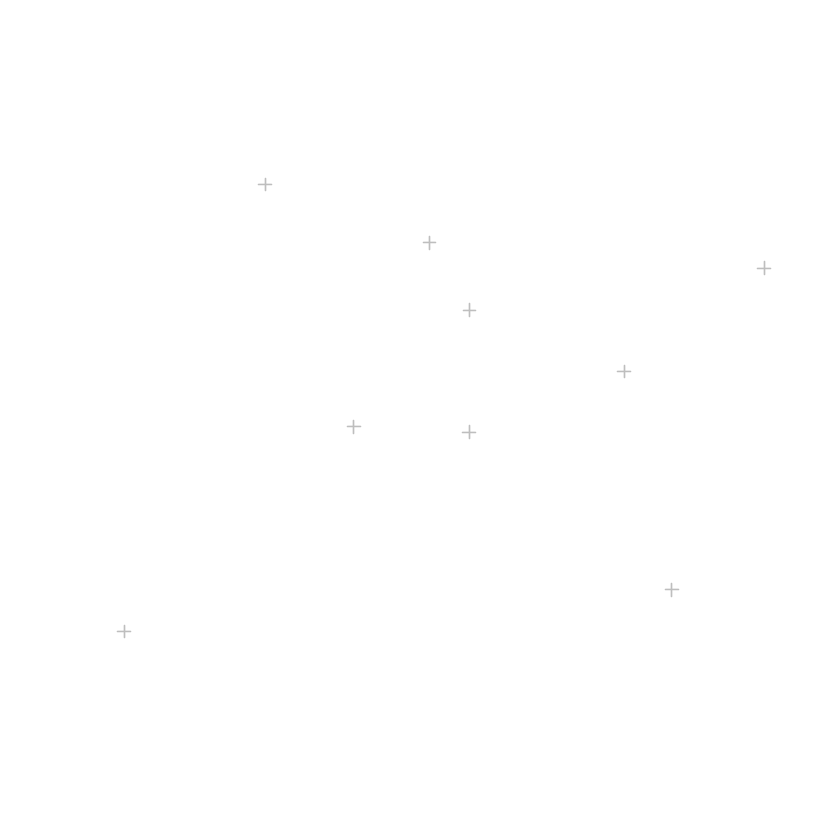

In [38]:
dsp <- readOGR(file.choose())
plot(dsp,col="grey")

## 3.shp格式转栅格

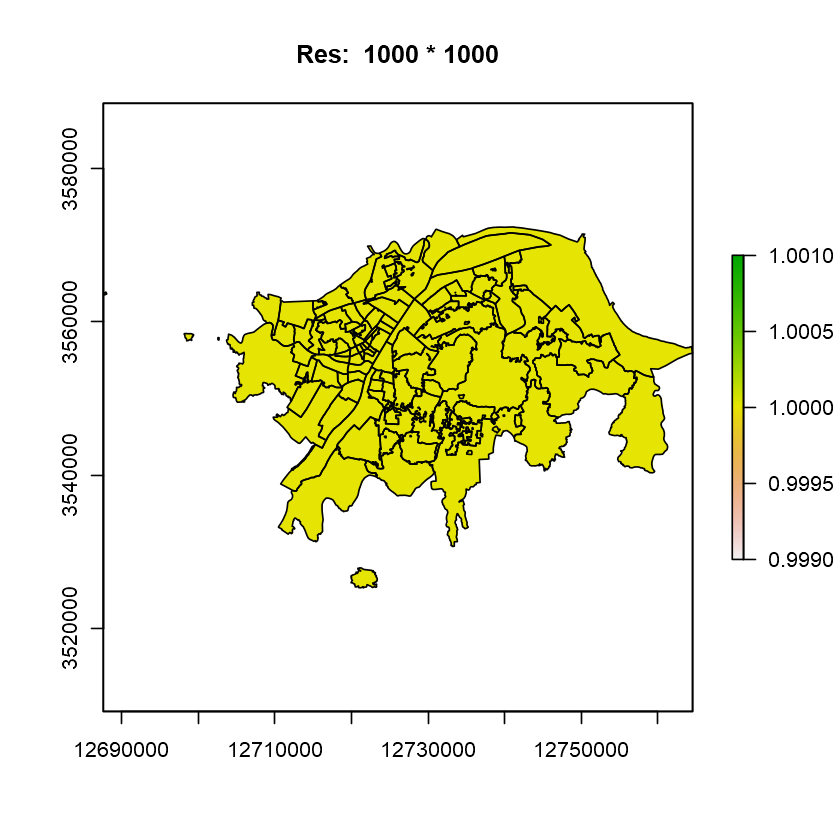

In [39]:
#layout(matrix(1:4, ncol=2, byrow=TRUE))
#res<-c(20,100,500,1000)
#上述代码测试栅格合适分辨率时开启
res<-c(1000)
for(r in res){
blank_raster<-raster(nrow=r,ncol=r,extent(bound))
values(blank_raster)<-1
bound_raster<-rasterize(bound,blank_raster)
bound_raster[!(is.na(bound_raster))] <- 1
plot(bound_raster,main=paste("Res: ",r,"*",r))
plot(bound,add=T)
}

## 4.邻域多边形插值
>数据量太少，有警告

Warning message in proj4string(x):
"CRS object has comment, which is lost in output; in tests, see
https://cran.r-project.org/web/packages/sp/vignettes/CRS_warnings.html"


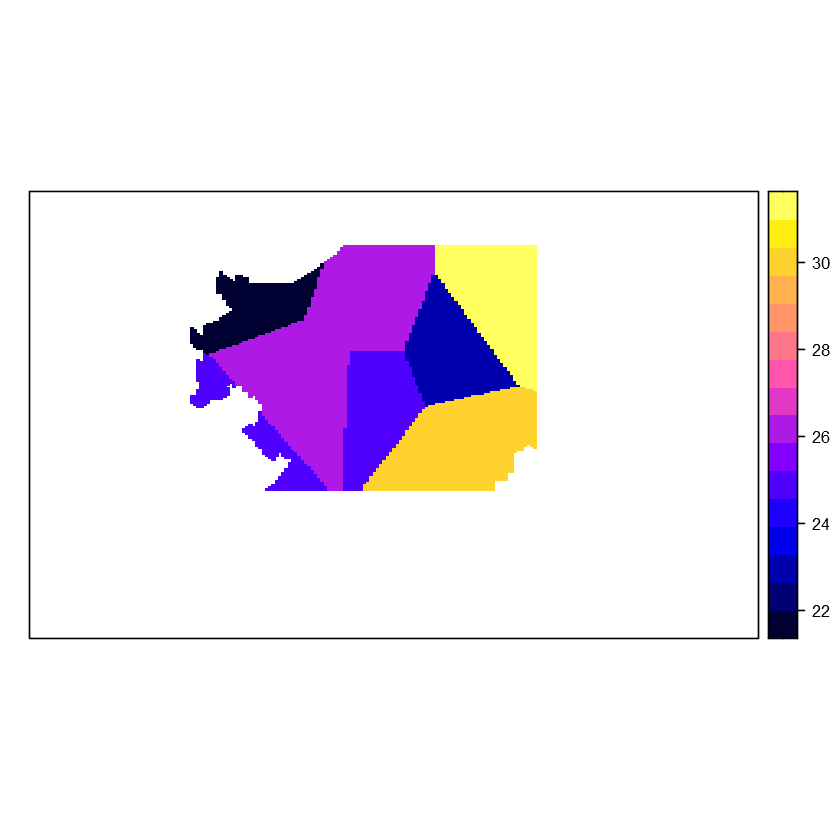

In [40]:
v <- voronoi(dsp)
v1<-intersect(v,bound)
#spplot(v1, "C", col.regions=rev(get_col_regions()))
vr <- rasterize(v1,bound_raster,"C")
spplot(vr)

## 5.最近邻点插值

[inverse distance weighted interpolation]


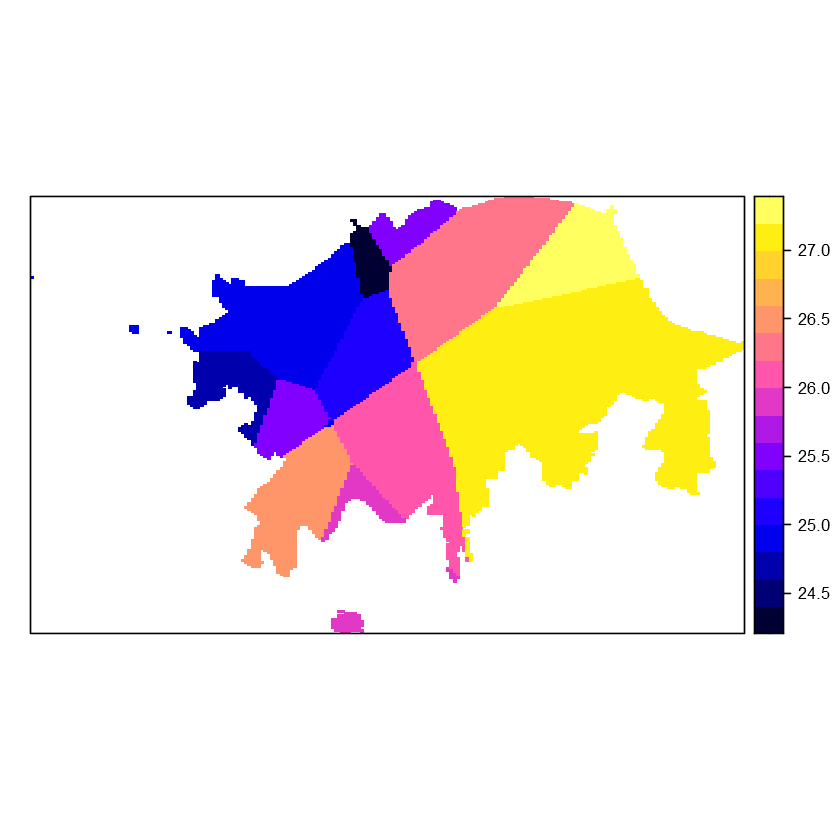

In [41]:
gs<-gstat(formula=C~1,location=dsp,nmax=5,set=list(idp=0))
nn<-interpolate(bound_raster,gs)
nnmask<-mask(nn,bound_raster)##掩膜提取
spplot(nnmask)

## 6.反距离加权插值

[inverse distance weighted interpolation]


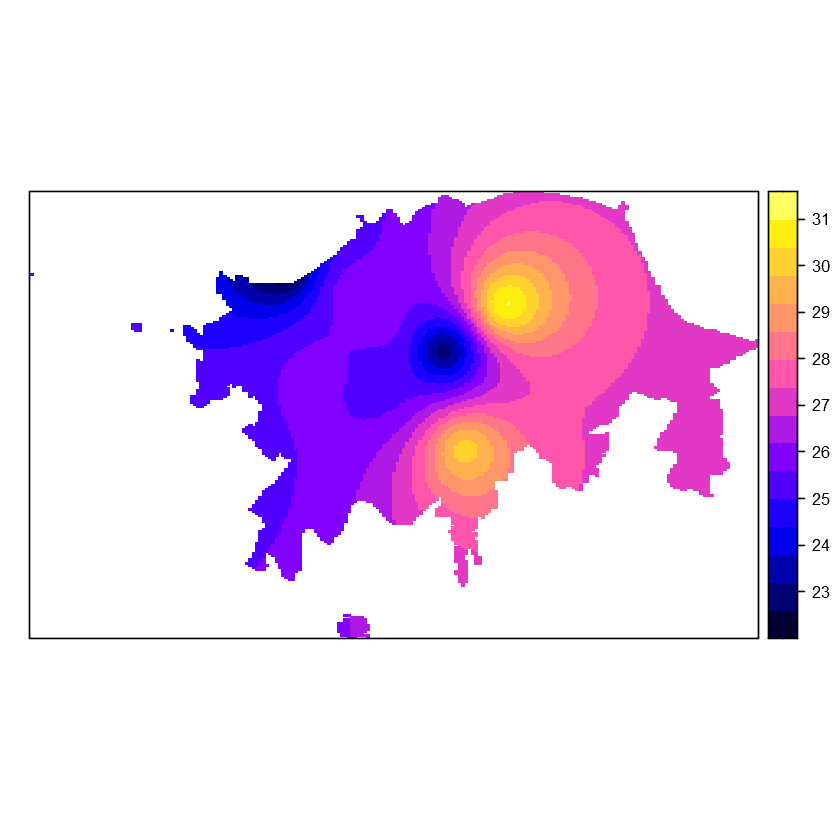

In [42]:
gs <- gstat(formula=C~1, locations=dsp)
idw <- interpolate(bound_raster, gs)
idwmask<-mask(idw,bound_raster)
spplot(idwmask)

## 7.普通克里金插值

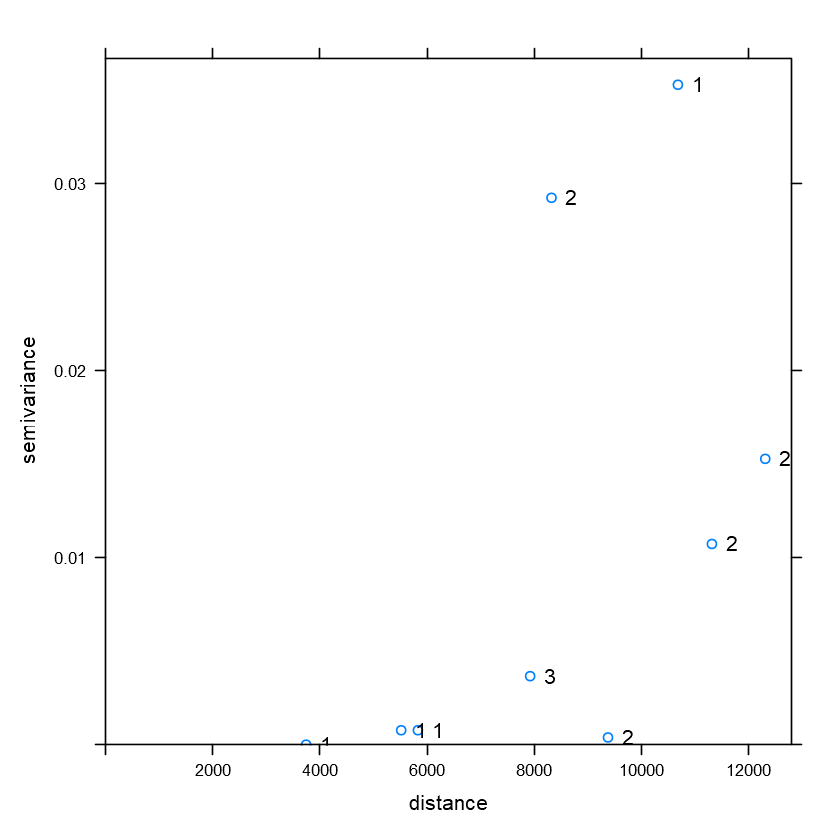

In [43]:
#求变异函数,绘制半变异图
v<- variogram(log(C) ~ 1, data =dsp)
plot(v,plot.number=T)

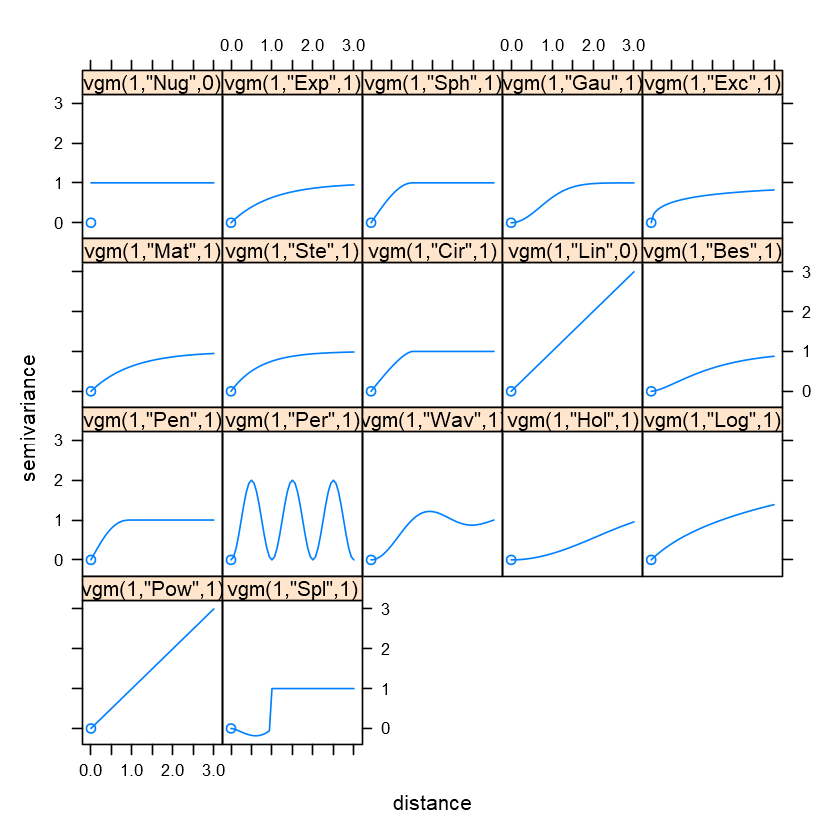

In [44]:
#选择合适的拟合函数
show.vgms()

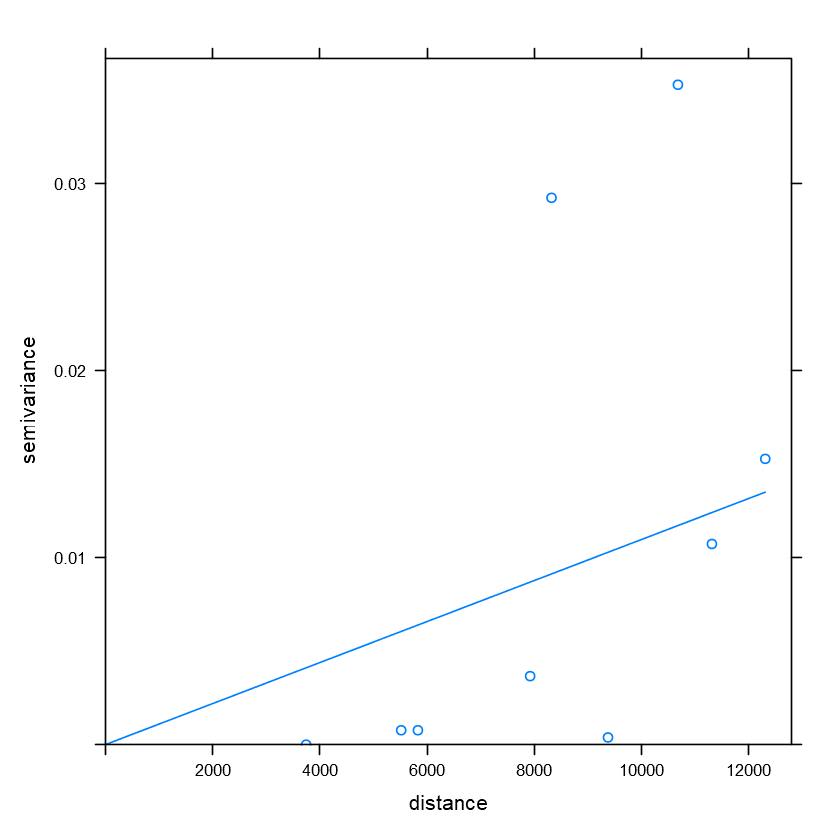

In [45]:
#拟合模型
v.fit<-fit.variogram(v,model=vgm(1,"Lin",0))
plot(v,v.fit)

[using ordinary kriging]


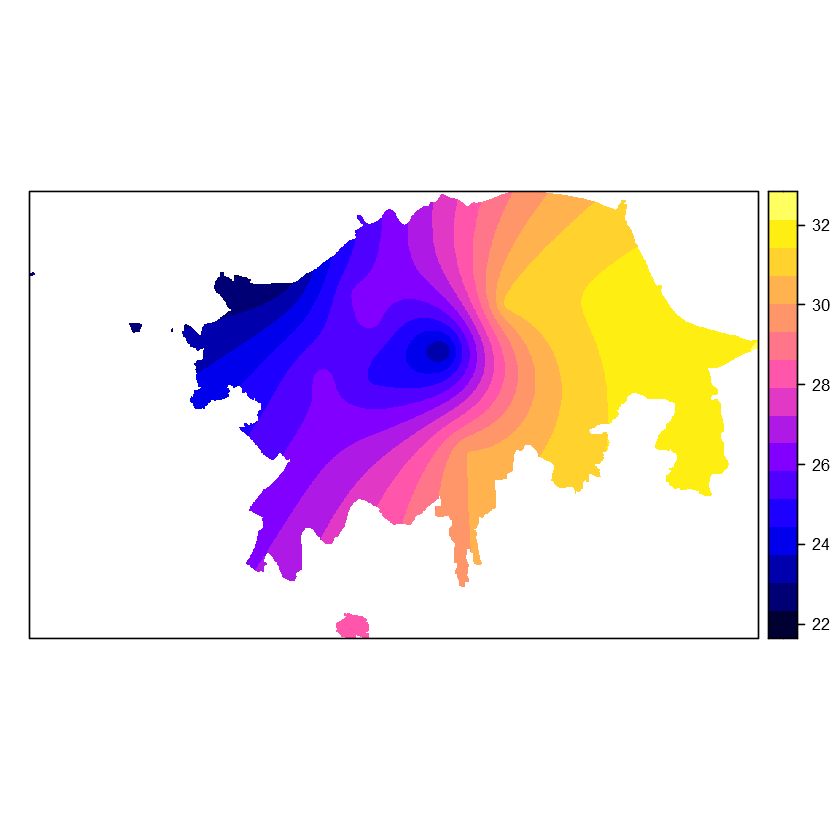

In [46]:
#点位数值预测
Grid<-as(bound_raster,"SpatialGridDataFrame")#首先现将边界栅格转成空间网格
kri<-krige(formula=C~1,model=v.fit,locations=dsp,newdata=Grid,nmax=12, nmin=10)#location为已知点的坐标；newdata为需要插值的点的位置；nmax和nmin分别代表最多和最少搜索点的个数
spplot(kri["var1.pred"])

### ArcGIS结果
![jupyter](./ARCGIS.png)

## 8.薄盘样条函数

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0002461982 (eff. df= 8.550006 )


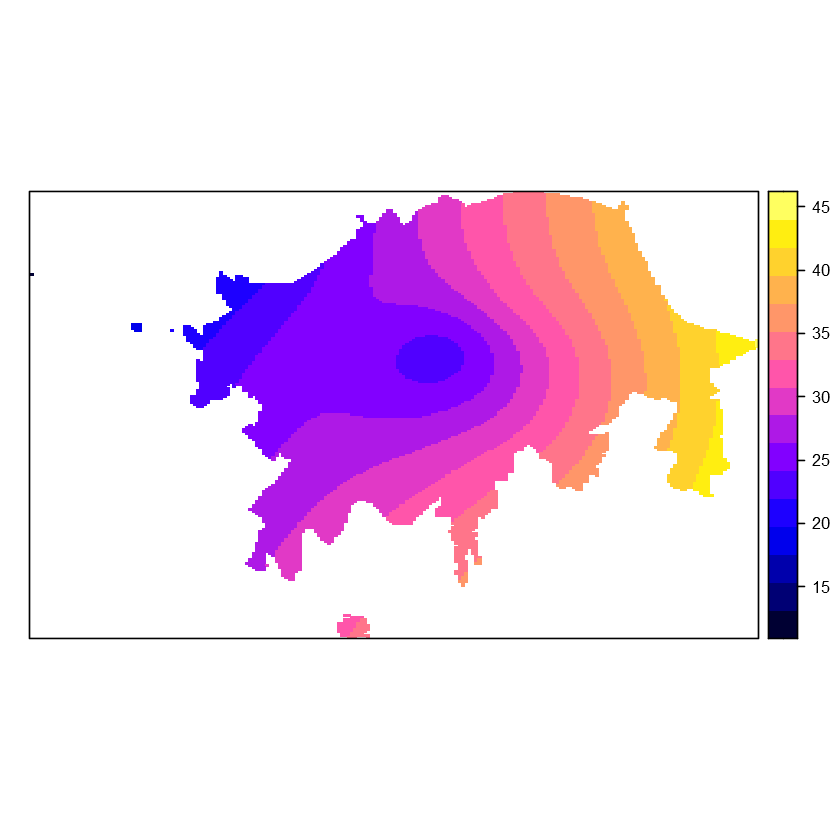

In [47]:
m <- Tps(coordinates(dsp), dsp$C)
tps <- interpolate(bound_raster, m)
tps <- mask(tps, bound_raster)
spplot(tps)

>[参考网址;https://zhuanlan.zhihu.com/p/39525002](https://zhuanlan.zhihu.com/p/39525002)